# Project 3

In [ ]:
# Import the required packages
import os
import torch
import torchvision
import cv2
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive. This notebook was prepared on Google Colab. The package for project 3 was uploaded to Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# GPU will be used throughout this notebook if available. If not, CPU will be used.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Data Loading

In [ ]:
# Initialize the list to hold all images for training.
imgs_training = []
# List of names of all image files.
all_image_files = list(sorted(os.listdir(os.path.join("drive", "MyDrive", "project3", "images"))))
# 50% of the image files are selected for training.
image_files = all_image_files[:300]

# Iterate over each image to load and store in the list.
for image_file in image_files:
    img = cv2.imread(os.path.join("drive", "MyDrive", "project3", "images", image_file))
    # The pixel values are normalized to be within the range [0,1].
    img_tensor = torch.as_tensor(img, dtype=torch.float32) / 255.0
    imgs_training.append(img_tensor)

# Stack the list of tensors into a single tensor.
imgs_training = torch.stack(imgs_training, 0)
# Axes are swapped to comply with the input requirements of the model.
imgs_training = imgs_training.swapaxes(1, 3).swapaxes(2, 3)

In [ ]:
# List of names of all mask files.
all_mask_files_person = sorted([file for file in os.listdir(os.path.join("drive", "MyDrive", "project3", "labels")) if "_person" in file])
# 50% of the mask files are selected for training.
mask_files_person = all_mask_files_person[:300]
# Initialize the list to hold all targets for training.
targets_person_training = []

# Iterate over each mask file to load and store in the list.
for mask_file in mask_files_person:
    mask = read_image(os.path.join("drive", "MyDrive", "project3", "labels", mask_file))
    target = {}
    # Unique object IDs, i.e. labels, in the mask.
    obj_ids = torch.unique(mask)
    # 0 refers to the background and does not need to be included in the target.
    obj_ids = obj_ids[1:]

    # Create boolean masks indicating where elements of the `mask` tensor match any of the object IDs in `obj_ids`.
    # Each element of `target_masks` corresponds to whether the corresponding element in `mask` matches any object ID.
    target_masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
    target["masks"] = torch.as_tensor(target_masks, dtype=torch.uint8)

    # The bounding boxes of the objects in the mask.
    target["boxes"] = masks_to_boxes(target_masks)

    # Unique labels in the mask without the background.
    labels = torch.unique(mask.flatten())
    labels = labels[1:]
    target["labels"] = labels.to(torch.int64)

    # Append the target to the list.
    targets_person_training.append(target)

In [ ]:
# List of names of all mask files.
all_mask_files_clothes = sorted([file for file in os.listdir(os.path.join("drive", "MyDrive", "project3", "labels")) if "_clothes" in file])
# 50% of the mask files are selected for training.
mask_files_clothes = all_mask_files_clothes[:300]
# Initialize the list to hold all targets for training.
targets_clothes_training = []

# Iterate over each mask file to load and store in the list.
for mask_file in mask_files_clothes:
    mask = read_image(os.path.join("drive", "MyDrive", "project3", "labels", mask_file))
    target = {}
    # Unique object IDs, i.e. labels, in the mask.
    obj_ids = torch.unique(mask)
    # 0 refers to the background and does not need to be included in the target.
    obj_ids = obj_ids[1:]

    # Create boolean masks indicating where elements of the `mask` tensor match any of the object IDs in `obj_ids`.
    # Each element of `target_masks` corresponds to whether the corresponding element in `mask` matches any object ID.
    target_masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
    target["masks"] = torch.as_tensor(target_masks, dtype=torch.uint8)

    # The bounding boxes of the objects in the mask.
    target["boxes"] = masks_to_boxes(target_masks)

    # Unique labels in the mask without the background.
    labels = torch.unique(mask.flatten())
    labels = labels[1:]
    target["labels"] = labels.to(torch.int64)

    # Append the target to the list.
    targets_clothes_training.append(target)

## Pixel Labeling of a Person

### Model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 183MB/s]


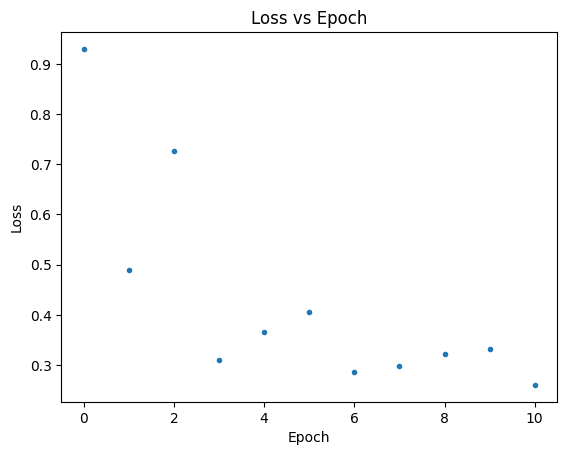

In [ ]:
# Mask R-CNN model from the torchvision library with pre-trained weights is loaded.
model_person = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# Number of input features for the classifier.
in_features = model_person.roi_heads.box_predictor.cls_score.in_features
# There are two classes in this model including 'background'.
model_person.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)
model_person.to(device)

# Initialize an AdamW optimizer for updating the parameters of the model.
optimizer = torch.optim.AdamW(params=model_person.parameters(), lr=0.0001)

model_person.train()

# List to store loss values to be used in displaying the learning curve.
losses_list = []

#Iterate through each epoch.
for i in range(11): #INITIALLY SET TO 101
    #Randomly select 10 images from the training set.
    random_numbers = [random.randint(0, 299) for x in range(10)]
    curr_imgs_training = [imgs_training[j] for j in random_numbers]
    images = list(image.to(device) for image in curr_imgs_training)
    curr_targets_person_training = [targets_person_training[j] for j in random_numbers]
    targets = [{k: v.to(device) for k, v in t.items()} for t in curr_targets_person_training]

    # Reset the gradients of the parameter to prepare for the next batch.
    optimizer.zero_grad()

    # Forward pass to get the loss.
    loss_dict = model_person(images, targets)

    # Calculate the total loss.
    losses = sum(loss for loss in loss_dict.values())

    # Backward pass to calculate the gradients.
    losses.backward()

    # Take a single optimization step to update the model parameters based on computed gradients and the optimizer's update rule.
    optimizer.step()

    losses_list.append(losses.item())
    if i%10==0:
        torch.save(model_person.state_dict(), str(i)+".torch")

# Display the training loss curve
plt.scatter(range(len(losses_list)), losses_list, marker='.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

### Validation
*Note:*

*1. Predicted mask files are stored in a new folder under the "project3" folder called "test".*

*2. Pixels of masks displayed in the report have been multiplied by 255 to make the different classes visible. The code below labels each pixel as 0 or 1 in align with the project requirement and the input required by evalseg.m.*

In [ ]:
def create_mask_from_target(target_dict, output_path):
    threshold = 0.75

    # Filter predictions based on score threshold.
    high_score_indices = target_dict["scores"] > threshold
    filtered_labels = target_dict["labels"][high_score_indices].cpu().numpy()
    filtered_masks = target_dict["masks"][high_score_indices].cpu().numpy()

    # To handle the edge-case where none of the masks cross the threshold when testing on unseen data,
    # all available predicted masks are included.
    if filtered_labels.size == 0:
        filtered_labels = target_dict["labels"].cpu().numpy()
        filtered_masks = target_dict["masks"].cpu().numpy()

    # Create combined mask.
    combined_mask = np.zeros_like(filtered_masks[0], dtype=np.uint8)
    for label, mask in zip(filtered_labels, filtered_masks):
        combined_mask[mask > 0] = label

    # Save the mask image.
    combined_mask_pil = Image.fromarray(combined_mask.squeeze(), mode='L')
    combined_mask_pil.save(output_path)

# Load the final stage of the trained model and set to evaluate.
model_person.load_state_dict(torch.load("10.torch")) #INITIALLY 100
model_person.to(device)
model_person.eval()

# Select 10% of images for validation.
image_validation_files = all_image_files[300:360]

# Iterate through each image.
for image in image_validation_files:
    images = cv2.imread(os.path.join("drive", "MyDrive", "project3", "images", image))
    images = torch.as_tensor(images, dtype=torch.float32) / 255.0
    images = images.permute(2,0,1).unsqueeze(0)
    images = images.to(device)

    # Get the prediction output of the model.
    with torch.no_grad():
        pred = model_person(images)

    # Get the image number and create the appropriate file name and output path.
    img_number = image[:-4]
    output_path = os.path.join("drive", "MyDrive", "project3", "validation", img_number + "_person.png")
    create_mask_from_target(pred[0], output_path)

### Test
*Note:*

*1. Predicted mask files are stored in a new folder under the "project3" folder called "test".*

*2. Pixels of masks displayed in the report have been multiplied by 255 to make the different classes visible. The code below labels each pixel as 0 or 1 in align with the project requirement and the input required by evalseg.m.*

In [ ]:
def create_mask_from_target(target_dict, output_path):
    threshold = 0.75

    # Filter predictions based on score threshold.
    high_score_indices = target_dict["scores"] > threshold
    filtered_labels = target_dict["labels"][high_score_indices].cpu().numpy()
    filtered_masks = target_dict["masks"][high_score_indices].cpu().numpy()

    # To handle the edge-case where none of the masks cross the threshold when testing on unseen data,
    # all available predicted masks are included.
    if filtered_labels.size == 0:
        filtered_labels = target_dict["labels"].cpu().numpy()
        filtered_masks = target_dict["masks"].cpu().numpy()

    # Create combined mask.
    combined_mask = np.zeros_like(filtered_masks[0], dtype=np.uint8)
    for label, mask in zip(filtered_labels, filtered_masks):
        combined_mask[mask > 0] = label

    # Save the mask image.
    combined_mask_pil = Image.fromarray(combined_mask.squeeze(), mode='L')
    combined_mask_pil.save(output_path)

# Load the final stage of the trained model and set to evaluate.
model_person.load_state_dict(torch.load("10.torch")) #INITIALLY 100
model_person.to(device)
model_person.eval()

# Select 40% of images for testing.
image_validation_files = all_image_files[360:]

# Iterate through each image.
for image in image_validation_files:
    images = cv2.imread(os.path.join("drive", "MyDrive", "project3", "images", image))
    images = torch.as_tensor(images, dtype=torch.float32) / 255.0
    images = images.permute(2,0,1).unsqueeze(0)
    images = images.to(device)

    # Get the prediction output of the model.
    with torch.no_grad():
        pred = model_person(images)

    # Get the image number and create the appropriate file name and output path.
    img_number = image[:-4]
    output_path = os.path.join("drive", "MyDrive", "project3", "test", img_number + "_person.png")
    create_mask_from_target(pred[0], output_path)

## Pixel Labeling of Clothing Items

### Model

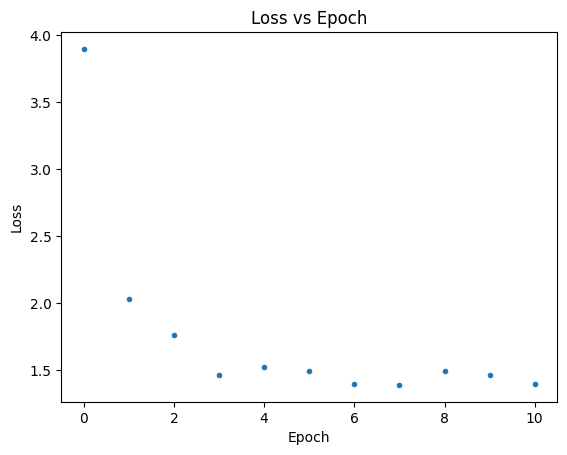

In [ ]:
# Mask R-CNN model from the torchvision library with pre-trained weights is loaded.
model_clothes = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# Number of input features for the classifier.
in_features = model_clothes.roi_heads.box_predictor.cls_score.in_features
# There are seven classes in this model including 'background'.
model_clothes.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=7)
model_clothes.to(device)

# Initialize an AdamW optimizer for updating the parameters of the model.
optimizer = torch.optim.AdamW(params=model_clothes.parameters(), lr=0.0001)

model_clothes.train()

# List to store loss values to be used in displaying the learning curve.
losses_list = []

#Iterate through each epoch.
for i in range(11): #INITIALLY SET TO 501
    #Randomly select 10 images from the training set.
    random_numbers = [random.randint(0, 299) for x in range(10)]
    curr_imgs_training = [imgs_training[j] for j in random_numbers]
    images = list(image.to(device) for image in curr_imgs_training)
    curr_targets_clothes_training = [targets_clothes_training[j] for j in random_numbers]
    targets = [{k: v.to(device) for k, v in t.items()} for t in curr_targets_clothes_training]

    # Reset the gradients of the parameter to prepare for the next batch.
    optimizer.zero_grad()

    # Forward pass to get the loss.
    loss_dict = model_clothes(images, targets)

    # Calculate the total loss.
    losses = sum(loss for loss in loss_dict.values())

    # Backward pass to calculate the gradients.
    losses.backward()

    # Take a single optimization step to update the model parameters based on computed gradients and the optimizer's update rule.
    optimizer.step()
    losses_list.append(losses.item())
    if i%10==0:
        torch.save(model_clothes.state_dict(), str(i)+".torch")

# Display the training loss curve
plt.scatter(range(len(losses_list)), losses_list, marker='.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

### Validation
*Note:*

*1. Predicted mask files are stored in a new folder under the "project3" folder called "test".*

*2. Pixels of masks displayed in the report have been multiplied by 255 to make the different classes visible. The code below labels each pixel between 0-6 in align with the project requirement and the input required by evalseg.m.*

In [ ]:
def create_mask_from_target(target_dict, output_path):
    threshold = 0.75

    # Filter predictions based on score threshold.
    high_score_indices = target_dict["scores"] > threshold
    filtered_labels = target_dict["labels"][high_score_indices].cpu().numpy()
    filtered_masks = target_dict["masks"][high_score_indices].cpu().numpy()

    # To handle the edge-case where none of the masks cross the threshold when testing on unseen data,
    # all available predicted masks are included.
    if filtered_labels.size == 0:
        filtered_labels = target_dict["labels"].cpu().numpy()
        filtered_masks = target_dict["masks"].cpu().numpy()

    # Create combined mask.
    combined_mask = np.zeros_like(filtered_masks[0], dtype=np.uint8)
    for label, mask in zip(filtered_labels, filtered_masks):
        combined_mask[mask > 0] = label

    # Save the mask image.
    combined_mask_pil = Image.fromarray(combined_mask.squeeze(), mode='L')
    combined_mask_pil.save(output_path)

# Load the final stage of the trained model and set to evaluate.
model_clothes.load_state_dict(torch.load("10.torch")) #INITALLY SET TO 500
model_clothes.to(device)
model_clothes.eval()

# Select 10% of images for validation.
image_validation_files = all_image_files[300:360]

# Iterate through each image.
for image in image_validation_files:
    images = cv2.imread(os.path.join("drive", "MyDrive", "project3", "images", image))
    images = torch.as_tensor(images, dtype=torch.float32) / 255.0
    images = images.permute(2,0,1).unsqueeze(0)
    images = images.to(device)

    # Get the prediction output of the model.
    with torch.no_grad():
        pred = model_clothes(images)

    # Get the image number and create the appropriate file name and output path.
    img_number = image[:-4]
    output_path = os.path.join("drive", "MyDrive", "project3", "validation", img_number + "_clothes.png")
    create_mask_from_target(pred[0], output_path)

### Test
*Note:*

*1. Predicted mask files are stored in a new folder under the "project3" folder called "test".*

*2. Pixels of masks displayed in the report have been multiplied by 255 to make the different classes visible. The code below labels each pixel between 0-6 in align with the project requirement and the input required by evalseg.m.*

In [ ]:
def create_mask_from_target(target_dict, output_path):
    threshold = 0.75

    # Filter predictions based on score threshold.
    high_score_indices = target_dict["scores"] > threshold
    filtered_labels = target_dict["labels"][high_score_indices].cpu().numpy()
    filtered_masks = target_dict["masks"][high_score_indices].cpu().numpy()

    # To handle the edge-case where none of the masks cross the threshold when testing on unseen data,
    # all available predicted masks are included.
    if filtered_labels.size == 0:
        filtered_labels = target_dict["labels"].cpu().numpy()
        filtered_masks = target_dict["masks"].cpu().numpy()

    # Create combined mask.
    combined_mask = np.zeros_like(filtered_masks[0], dtype=np.uint8)
    for label, mask in zip(filtered_labels, filtered_masks):
        combined_mask[mask > 0] = label

    # Save the mask image.
    combined_mask_pil = Image.fromarray(combined_mask.squeeze(), mode='L')
    combined_mask_pil.save(output_path)

# Load the final stage of the trained model and set to evaluate.
model_clothes.load_state_dict(torch.load("10.torch")) #INITALLY SET TO 500
model_clothes.to(device)
model_clothes.eval()

# Select 40% of images for testing.
image_validation_files = all_image_files[360:]

# Iterate through each image.
for image in image_validation_files:
    images = cv2.imread(os.path.join("drive", "MyDrive", "project3", "images", image))
    images = torch.as_tensor(images, dtype=torch.float32) / 255.0
    images = images.permute(2,0,1).unsqueeze(0)
    images = images.to(device)

    # Get the prediction output of the model.
    with torch.no_grad():
        pred = model_clothes(images)

    # Get the image number and create the appropriate file name and output path.
    img_number = image[:-4]
    output_path = os.path.join("drive", "MyDrive", "project3", "test", img_number + "_clothes.png")
    create_mask_from_target(pred[0], output_path)

## References


---



*Note: The mask R-CNN model provided in the PyTorch’s torchvision package was used in the code to build the model and described in detail in the report. References that have been included below of coding tutorials were mostly used to develop an understanding of the package and the model before adapting the information for the specific use of this project. Special focus was given to not copy any sections of code directly.*

[1] G. Gkioxari, K. He, P. Dollar, and R. Girshick, "Mask R-CNN," Facebook AI Research (FAIR), January 2018.

[2] G. Patterson, J. Hays, L. Bourdev, L. Zitnick, M. R. Ronchi, M. Maire, R. Girshick, S. Belongie, T. Lin, P. Perona, D. Ramanan, P. Dollar, and Y. Cui, "What is COCO?", COCO, 2015. [Online]. Available: https://cocodataset.org/#home. [Accessed: April, 2024].

[3] K. Yamaguchi, M. H. Kiapour, L. E. Ortiz, T. L. Berg. “Parsing Clothing in Fashion Photographs,” CVPR, 2012.

[4] P. Potrimba, "What is Mask R-CNN? The Ultimate Guide." Roboflow, 2023. [Online]. Available: https://blog.roboflow.com/mask-rcnn/. [Accessed: April, 2024].

[5] PyTorch, "maskrcnn_resnet50_fpn," PyTorch, 2017. [Online]. Available: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html. [Accessed: April, 2024].

[6] PyTorch, "Visualization utilities," PyTorch, 2017. [Online]. Available: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html. [Accessed: April, 2024].

[7] PyTorch, "TorchVision Object Detection Finetuning Tutorial," PyTorch, 2017. [Online]. Available: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html. [Accessed: April, 2024].

[8] S. Eppel, "Train Mask R-CNN Net for Object Detection in 60 Lines of Code," Towards Data Science, 2022. [Online]. Available: https://towardsdatascience.com/train-mask-rcnn-net-for-object-detection-in-60-lines-of-code-9b6bbff292c3. [Accessed: April, 2024].
